**Importing the required packages**

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

**Reading the dataset**

In [ ]:
db = pd.read_csv("https://raw.githubusercontent.com/surbhi-kh/Data_Analytics/main/diabetes.csv")
print("\n" + 20*"#" + " " + "The First 5 Data Values".center(20) + " " + 20*"#")
print(db.head())
print("\n" + 20 * "#" + " " + "The Last 5 Data Values".center(20) + " " + 20 * "#")
print(db.tail())


#################### The First 5 Data Values ####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

#################### The Last 5 Data Values ####################
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
763           10      101             76             48      180  32.9   
764            2      

In [ ]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We saw that there are only numerical values in this dataset. 768 observations and 9 variables are present.

In [ ]:
print(db.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


It can be seen that there are no null values but there can still be missing values.

In [ ]:
db.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


We know that glucode, age, skin thickness, insulin, BMI and blood pressure cannot be zero (invalid value). So converting then to null values.

In [ ]:
variable = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI", "Age"]
db[variable] = db[variable].replace(0,np.NaN)
db.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Therefore, now we can see that there were many invalid values in some columns, which could have lead to error in further analysis.

**Now analyzing the target variable**

In [ ]:
db["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [ ]:
attributes = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'Age']
def outcome_summary(data, target, column):
  print(data.groupby(target).agg({column : 'mean'}), end = "\n")
  print("\n")

for col in attributes:
  outcome_summary(db, 'Outcome', col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        110.643863
1        142.319549


         BloodPressure
Outcome               
0            70.877339
1            75.321429


         SkinThickness
Outcome               
0            27.235457
1            33.000000


            Insulin
Outcome            
0        130.287879
1        206.846154


               BMI
Outcome           
0        30.859674
1        35.406767


               Age
Outcome           
0        31.190000
1        37.067164




**Checking Outliers**

In [ ]:
def outlier_threshold(data, col, q1=0.25, q3=0.75):
    quartile1 = data[col].quantile(q1)
    quartile3 = data[col].quantile(q3)
    interquartile_range = quartile3 - quartile1
    
    # Calculate the upper and lower limits for outliers
    lower_limit = quartile1 - 1.5 * interquartile_range
    upper_limit = quartile3 + 1.5 * interquartile_range

    return lower_limit, upper_limit

In [ ]:
def check_outlier(data, col):
    lower_limit, upper_limit = outlier_threshold(data, col)
    
    # Check if any values in the column exceed the upper limit or fall below the lower limit
    if data[(data[col] > upper_limit) | (data[col] < lower_limit)].any(axis = None):
        return True
    else:
        return False

In [ ]:
for col in attributes:
    print(col, check_outlier(db, col))

Pregnancies True
Glucose False
BloodPressure True
SkinThickness True
Insulin True
BMI True
Age True


There are outliers in all columns except Glucose. Now replacing the outliers with the threshold value.

In [ ]:
def replace(data, col):
    lower_limit, upper_limit = outlier_threshold(data, col)
    data.loc[(data[col] < lower_limit), col] = lower_limit
    data.loc[(data[col] > upper_limit), col] = upper_limit

In [ ]:
for col in attributes:
    replace(db, col)

In [ ]:
for col in attributes:
    print(col, check_outlier(db, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
Age False


The outliers have been fixed. Now checking for missing values and filling it.

In [ ]:
def missing_values(data, na = False):
  var = [col for col in attributes if data[col].isnull().sum() > 0]
  miss = data[var].isnull().sum()
  print(miss, end = "\n")
  
missing_values(db)

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


Filling the missing values with median values of the corresponding column as that would be the safest option.

In [ ]:
db["Glucose"] = db["Glucose"].fillna(db["Glucose"].median())
db["BloodPressure"] = db["BloodPressure"].fillna(db["BloodPressure"].median())
db["BMI"] = db["BMI"].fillna(db["BMI"].median())

Now implementing the **KNN method** to fill the Insulin and SkinThickening columns. Creating a new dataframe consisting of dummy variables. 

In [ ]:
dummy = pd.get_dummies(db[["Insulin","SkinThickness"]], drop_first=True)

In [ ]:
imputer = KNNImputer(n_neighbors=5)
dummy = pd.DataFrame(imputer.fit_transform(dummy), columns=dummy.columns)
dummy.head()

,Insulin,SkinThickness
0,197.525,35.00000
1,140.600,29.00000
2,146.500,29.05915
3,94.000,23.00000
4,168.000,35.00000


Copying the values from dummy dataframe to our original dataframe

In [ ]:
db["Insulin"] = dummy["Insulin"]
db["SkinThickness"]= dummy["SkinThickness"]

In [ ]:
db.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
db.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.00000,197.525,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.00000,140.600,26.6,0.351,31.0,0
2,8.0,183.0,64.0,29.05915,146.500,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.00000,94.000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.00000,168.000,43.1,2.288,33.0,1


**Now creating new feature interactions**
 >Making Glucose, Age, BMI, Insulin and Blood Pressure Categorical variable.

In [ ]:
db.loc[(db['Glucose'] < 70), 'GLUCOSE_CAT'] ="hipoglisemi"
db.loc[(db['Glucose'] >= 70) & (db['Glucose'] < 100) , 'GLUCOSE_CAT'] ="normal"
db.loc[(db['Glucose'] >= 100) & (db['Glucose'] < 126) , 'GLUCOSE_CAT'] ="imparied glucose"
db.loc[(db['Glucose'] >= 126), 'GLUCOSE_CAT'] ="hiperglisemi"

db.groupby("GLUCOSE_CAT").agg({"Outcome": ["mean","count"]})

Outcome      
                      mean count
GLUCOSE_CAT                     
hiperglisemi      0.592593   297
hipoglisemi       0.000000    11
imparied glucose  0.279570   279
normal            0.077348   181

We observe that Women with hyperglycemia will have a higher chances of diabetes.

In [ ]:
db.loc[(db['Age'] >= 18) & (db['Age'] < 30) , 'AGE_CAT'] ="young_women_"
db.loc[(db['Age'] >= 30) & (db['Age'] < 45) , 'AGE_CAT'] ="mature_women"
db.loc[(db['Age'] >= 45) & (db['Age'] < 60) , 'AGE_CAT'] ="middle_age"
db.loc[(db['Age'] >= 60) & (db['Age'] < 75) , 'AGE_CAT'] ="old_age"
db.loc[(db['Age'] >= 75) , 'AGE_CAT'] ="elder_age"

db.groupby("AGE_CAT").agg({"Outcome": ["mean","count"]})

Outcome      
                  mean count
AGE_CAT                     
mature_women  0.493724   239
middle_age    0.564356   101
old_age       0.281250    32
young_women_  0.212121   396

Middle aged women have higher chances of diabetes on average outcome.

In [ ]:
db.loc[(db['BMI'] < 18), 'BMI_CAT'] ="Underweight"
db.loc[(db['BMI'] >= 18) & (db['BMI'] < 25) , 'BMI_CAT'] ="Normal"
db.loc[(db['BMI'] >= 25) & (db['BMI'] < 30) , 'BMI_CAT'] ="Overweight"
db.loc[(db['BMI'] >= 30) & (db['BMI'] < 45) , 'BMI_CAT'] ="Obese"
db.loc[(db['BMI'] >= 45), 'BMI_CAT'] ="Severly Obese"

db.groupby("BMI_CAT").agg({"Outcome": ["mean","count"]})

Outcome      
                   mean count
BMI_CAT                      
Normal         0.066038   106
Obese          0.445190   447
Overweight     0.223464   179
Severly Obese  0.611111    36

Obese Women will have a higher incidence of diabetes on average outcome.

In [ ]:
db.loc[(db['BloodPressure'] < 70)  , 'BP_CAT'] ="Low"
db.loc[(db['BloodPressure'] >= 70) & (db['BMI'] < 90) , 'BP_CAT'] ="Normal"
db.loc[(db['BloodPressure'] >= 90 ) , 'BP_CAT'] ="High"

db.groupby("BP_CAT").agg({"Outcome": ["mean","count"]})

Outcome      
            mean count
BP_CAT                
High    0.483333    60
Low     0.247350   283
Normal  0.397647   425

 Women with high blood pressure will have a higher incidence of diabetes on average outcome.

In [ ]:
db.loc[(db['Insulin'] < 120)  , 'INSULIN_CAT'] ="normal"
db.loc[(db['Insulin'] >= 120) , 'INSULIN_CAT'] ="abnormal"

db.groupby("INSULIN_CAT").agg({"Outcome": ["mean","count"]})

Outcome      
                 mean count
INSULIN_CAT                
abnormal     0.428843   527
normal       0.174274   241

Women with abnormal insulin will have a higher incidence of diabetes on average the Outcome.

In [ ]:
db.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,GLUCOSE_CAT,AGE_CAT,BMI_CAT,BP_CAT,INSULIN_CAT
0,6.0,148.0,72.0,35.00000,197.525,33.6,0.627,50.0,1,hiperglisemi,middle_age,Obese,Normal,abnormal
1,1.0,85.0,66.0,29.00000,140.600,26.6,0.351,31.0,0,normal,mature_women,Overweight,Low,abnormal
2,8.0,183.0,64.0,29.05915,146.500,23.3,0.672,32.0,1,hiperglisemi,mature_women,Normal,Low,abnormal
3,1.0,89.0,66.0,23.00000,94.000,28.1,0.167,21.0,0,normal,young_women_,Overweight,Low,normal
4,0.0,137.0,40.0,35.00000,168.000,43.1,2.288,33.0,1,hiperglisemi,mature_women,Obese,Low,abnormal


We can observe from the graph that the general trends identified are valid and the data can be used for further analysis.

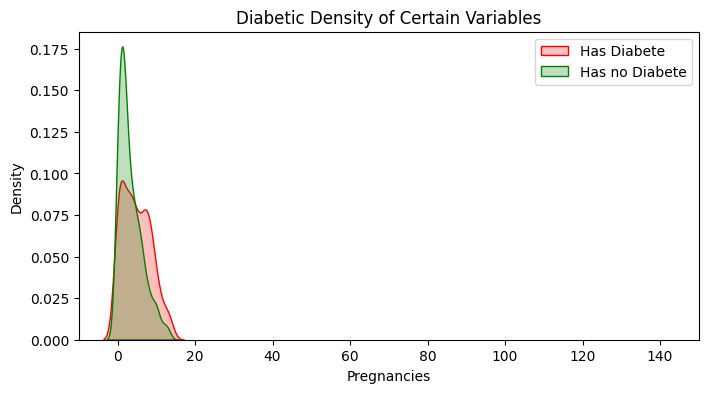

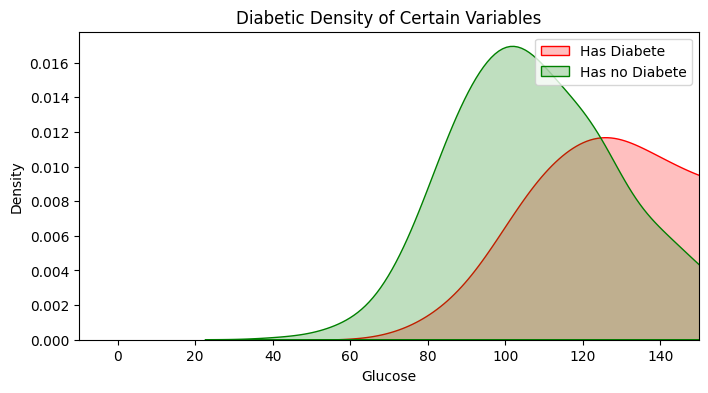

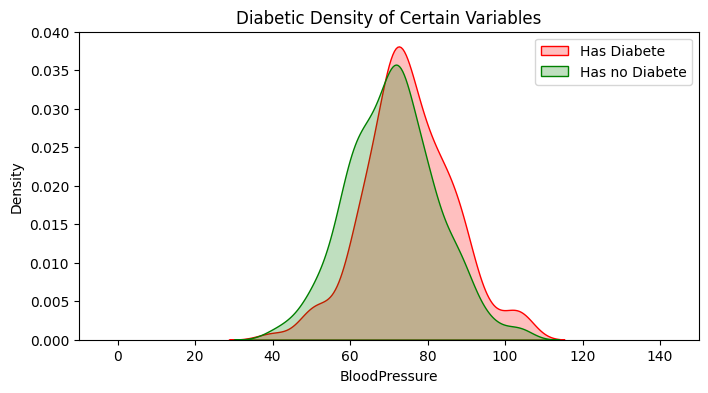

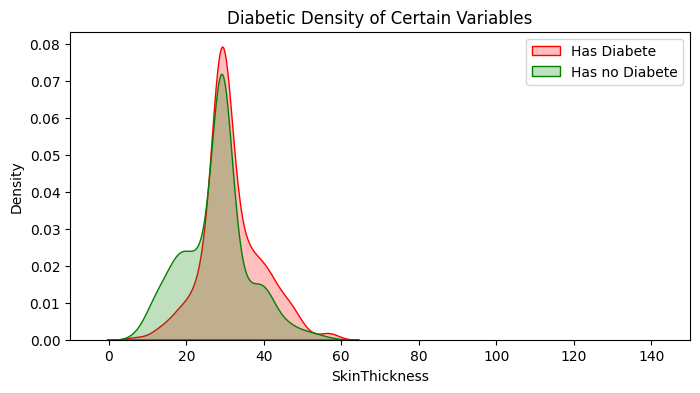

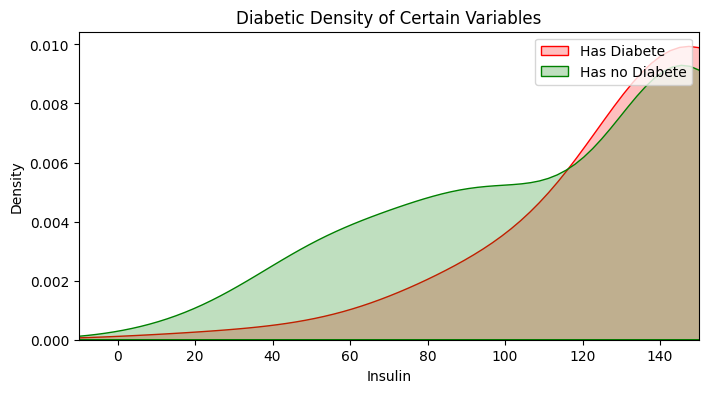

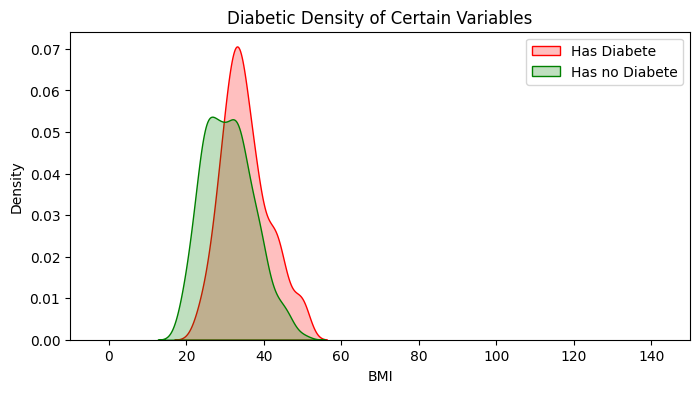

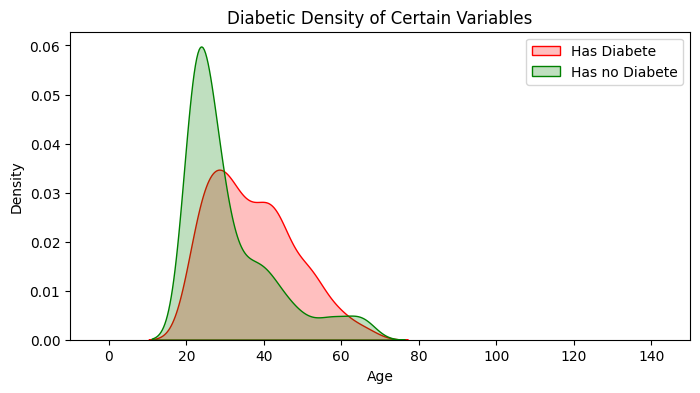

In [ ]:








def outcome_density(data, target, column):
  plt.figure(figsize=(8,4))
  #Plotting the data where the outcome is 1
  sns.kdeplot(db[column][db.Outcome == 1], color="red", fill=True)
  #Plotting the data where the outcome is 0
  sns.kdeplot(db[column][db.Outcome == 0], color="green", fill=True)
  plt.legend(['Has Diabete', 'Has no Diabete'])
  plt.xlim(-10,150)
  plt.title("Diabetic Density of Certain Variables")
  plt.show()
    
for col in attributes:
    outcome_density(db,"Outcome",col)



**The tasks performed are as follows:**

* Imported Libraries and Read Diabetes Dataset: The necessary libraries were imported, and the Diabetes dataset was read into the program.
* Exploratory Data Analysis: An analysis was conducted to examine the dataset, including checking for missing values. The target variable was analyzed, and outliers were identified.
* Data Preprocessing: Missing values in certain variables were filled using either the median values or the K-nearest neighbors (KNN) method.
* Feature Engineering: New feature interactions were created for categorical variables in order to enhance the dataset.